In [1]:
from table_loading_mod import *
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

pl.style.use('dark_background')
pl.rcParams['font.size'] = 16

/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
fulltbl = Table.read('/blue/adamginsburg/adamginsburg/ALMA_IMF/SPICY_ALMAIMF/SPICY_withAddOns.fits')
fulltbl.add_index('ALMAIMF_FIELDID')
tbl = fulltbl.loc['G328']

In [3]:
tbl[7]

SPICY,ra,dec,l,b,p1,p2,p3,class,silicate,pah,alpha,alpha_8,alpha_24,alpha_w4,env,group,var,nr,r,sigmar,skewnessr,Spitzer,mag3_6,e_mag3_6,mag4_5,e_mag4_5,mag5_8,e_mag5_8,mag8_0,e_mag8_0,csf,m3_6,m4_5,m5_8,m8_0,2MASS,UKIDSS,VIRAC,GaiaDR2,MIPS,AllWISE,ZTFDR3,in_ALMAIMF,ALMAIMF_FIELDID,70,160,250,350,500,Spitzer/MIPS.24mu_flux,Spitzer/MIPS.24mu_eflux,M24_flux_uplim,RA_ICRS,DE_ICRS,Ksmag,KsEll,pm,e_pm,pmRA,e_pmRA,pmDE,e_pmDE,Nep,flgrel,Zmag,Zell,Ymag,Yell,Jmag,Jell,Hmag,Hell,Zdetflg,Ydetflg,Jdetflg,Hdetflg,ALMA-IMF_3mm_flux,ALMA-IMF_3mm_eflux,ALMA-IMF_1mm_flux,ALMA-IMF_1mm_eflux,Paranal/VISTA.Y_flux,Paranal/VISTA.Y_eflux,Paranal/VISTA.Z_flux,Paranal/VISTA.Z_eflux,Paranal/VISTA.J_flux,Paranal/VISTA.J_eflux,Paranal/VISTA.H_flux,Paranal/VISTA.H_eflux,Paranal/VISTA.Ks_flux,Paranal/VISTA.Ks_eflux,Spitzer/IRAC.I1_flux,Spitzer/IRAC.I1_eflux,Spitzer/IRAC.I2_flux,Spitzer/IRAC.I2_eflux,Spitzer/IRAC.I3_flux,Spitzer/IRAC.I3_eflux,Spitzer/IRAC.I4_flux,Spitzer/IRAC.I4_eflux,Herschel/Pacs.blue_eflux,Herschel/Pacs.red_eflux,Herschel/SPIRE.PSW_eflux,Herschel/SPIRE.PMW_eflux,Herschel/SPIRE.PLW_eflux,Herschel/Pacs.blue_flux,Herschel/Pacs.red_flux,Herschel/SPIRE.PSW_flux,Herschel/SPIRE.PMW_flux,Herschel/SPIRE.PLW_flux
,deg,deg,deg,deg,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,Jy / pix,Jy / pix,MJy / sr,MJy / sr,MJy / sr,mJy,mJy,MJy / sr,deg,deg,mag,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,mag,,mag,,mag,,mag,,,,,,Jy / beam,Jy / beam,Jy / beam,Jy / beam,,,,,,,,,,,mJy,mag mJy,mJy,mag mJy,,mag,,mag,mJy,mJy,mJy,mJy,mJy,,,,,
int64,float64,float64,float64,float64,float32,float32,float32,bytes9,bool,bool,float64,float64,float64,float64,bytes7,bytes10,int16,int16,float64,float64,float64,bytes26,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,bytes18,bytes19,int32,int64,bytes18,bytes20,int64,bool,bytes8,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,int16,uint8,float64,float32,float64,float32,float32,float32,float64,float32,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
31432,239.505781,-53.971597,328.25402,-0.538444,0.8,--,--,uncertain,True,False,-0.981537079426799,-0.981537079426799,--,--,EnvIII,G328.2-0.5,--,--,--,--,--,SSTGLMC G328.2540-00.5384,14.437,0.105,12.791,0.129,11.667,0.097,11.674,0.301,0,3,2,3,1,,,-2147483648,--,,,--,True,G328,1.0928361400090547,2.9280155306949305,9070.176317305919,5517.693407685725,1972.280212975804,--,95.286,99.383156,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0024896317652718485,8.872360412077857e-05,0.003592109612510786,0.0003857492389422121,--,--,--,--,--,--,--,--,--,--,0.4656159,0.044852905,1.3694358,0.16207083,2.4520342,0.21820854,1.3267016,0.36636436,1092.8361400090548,2928.0155306949305,65816.1744989629,67383.51802539869,47279.04639233157,--,--,--,--,--


In [4]:
tbl.remove_indices('ALMAIMF_FIELDID')
tbl.add_index('SPICY')
tbl.sort('SPICY')

In [5]:
tbl['ALMA-IMF_3mm_flux'] = tbl['ALMA-IMF_3mm_flux'] * 10**3
tbl['ALMA-IMF_1mm_flux'] = tbl['ALMA-IMF_1mm_flux'] * 10**3

In [6]:
tbl['ALMA-IMF_3mm_eflux'] = tbl['ALMA-IMF_3mm_eflux'] * 10**3
tbl['ALMA-IMF_1mm_eflux'] = tbl['ALMA-IMF_1mm_eflux'] * 10**3

In [7]:
tbl['Paranal/VISTA.Y_eflux'].fill_value = 0.02084540283203125
tbl['Paranal/VISTA.Y_eflux'] = tbl['Paranal/VISTA.Y_eflux'].filled()

tbl['Paranal/VISTA.Z_eflux'].fill_value = 0.014287492998478904
tbl['Paranal/VISTA.Z_eflux'] = tbl['Paranal/VISTA.Z_eflux'].filled()

tbl['Paranal/VISTA.J_eflux'].fill_value = 0.0245767
tbl['Paranal/VISTA.J_eflux'] = tbl['Paranal/VISTA.J_eflux'].filled()

tbl['Paranal/VISTA.H_eflux'].fill_value = 0.025805469092337628
tbl['Paranal/VISTA.H_eflux'] = tbl['Paranal/VISTA.H_eflux'].filled()

tbl['Paranal/VISTA.Ks_eflux'].fill_value = 0.042246558
tbl['Paranal/VISTA.Ks_eflux'] = tbl['Paranal/VISTA.Ks_eflux'].filled()

In [8]:
tbl['Spitzer/MIPS.24mu_eflux'][tbl['Spitzer/MIPS.24mu_flux'].mask] = (tbl['M24_flux_uplim'][tbl['Spitzer/MIPS.24mu_flux'].mask].quantity * 2*np.pi*(6*u.arcsec)**2/(8*np.log(2))).to(u.mJy)

# Multi-geometry fitting

In [9]:
fieldid = 'G328'
spicyid = 31415

In [7]:
fulltbl = Table.read('/blue/adamginsburg/adamginsburg/ALMA_IMF/SPICY_ALMAIMF/SPICY_withAddOns.fits')
robitaille_modeldir = '/blue/adamginsburg/richardson.t/research/flux/robitaille_models/'
sed_filters, wavelength_dict, filternames, zpts = get_filters()
filters = filternames+["ALMA-IMF_1mm", "ALMA-IMF_3mm"]
extinction = make_extinction()

In [30]:
def source_fitting(rownum, geometry="s---s-i"):
    global model_dir, extinction, filters, apertures
    global source, flx, error, valid
    
    model_dir = f'{robitaille_modeldir}/{geometry}'
    extinction = make_extinction()
    filters = filternames+["ALMA-IMF_1mm", "ALMA-IMF_3mm"]
#    apertures = ([3]*(len(filters)))*u.arcsec
    apertures = [2, 2, 2, 2, 2, 2.4, 2.4, 2.4, 2.4, 6, 3, 3, 3, 3, 3, 3, 3]*u.arcsec
    source = Source()
    
    flx, error, valid = get_data_to_fit(rownum, tbl, filters=filters)
    print(f"valid={valid}")
    
    source.valid = valid
    source.flux = flx    
    source.error =  error
    
    fitter = Fitter(filter_names=np.array(filters),#[valid],
                    apertures=apertures,#[valid],
                    model_dir=model_dir,
                    extinction_law=extinction,
                    distance_range=[2.3,2.7]*u.kpc,
                    av_range=[5,40],
                   )
    
    fitinfo = fitter.fit(source)
    
    return fitinfo

------------

In [31]:
rownum = tbl.loc_indices[spicyid]

In [32]:
bestfits_source = {geom: source_fitting(rownum, geometry=geom) for geom in geometries}

valid=[3 3 3 3 1 1 1 1 0 3 3 3 3 3 3 1 1]
 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s---s-i
   Log[d] stepping     :  0.02
   Number of distances :  5

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Y.fits


   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Z.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.J.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.H.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Ks.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I1.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I2.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I3.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I4.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s--

------------

# Analysis

In [33]:
{geom: np.nanmin(fitinfo.chi2) for geom, fitinfo in bestfits_source.items()}

{'s---s-i': <Quantity 3.79048704e+14>,
 'sp--s-i': <Quantity 6.79215988e+12>,
 'sp--h-i': <Quantity 2.80883514e+12>,
 's---smi': <Quantity 4.27015475e+14>,
 'sp--smi': <Quantity 2.26022759e+13>,
 'sp--hmi': <Quantity 8.67200184e+12>,
 's-p-smi': <Quantity 5.24838645e+13>,
 's-p-hmi': <Quantity 6.68884204e+09>,
 's-pbsmi': <Quantity 1.38633445e+09>,
 's-pbhmi': <Quantity 1.31508756e+09>,
 's-u-smi': <Quantity 1.62682919e+13>,
 's-u-hmi': <Quantity 2.52733052e+09>,
 's-ubsmi': <Quantity 1.62853831e+13>,
 's-ubhmi': <Quantity 1.31705772e+09>,
 'spu-smi': <Quantity 8.33508779e+12>,
 'spu-hmi': <Quantity 1.30275356e+09>,
 'spubsmi': <Quantity 2.88366665e+11>,
 'spubhmi': <Quantity 1.30041336e+09>}

In [43]:
# geometries_selection = ["s-p-hmi","s-pbhmi","s-u-hmi"]

geometries_selection = ["s---s-i", "sp--s-i", "sp--h-i", 
                        "s---smi", "sp--smi", "sp--hmi", 
                        "s-p-smi", "s-p-hmi", "s-pbsmi", 
                        "s-pbhmi", "s-u-smi", "s-u-hmi", 
                        "s-ubsmi", "s-ubhmi", "spu-smi", 
                        "spu-hmi", "spubsmi", "spubhmi"]

In [44]:
chi2limit = 1000

In [41]:
sedcube = SEDCube.read(f"{model_dir}/flux.fits",)

In [45]:
apertures

<Quantity [2. , 2. , 2. , 2. , 2. , 2.4, 2.4, 2.4, 2.4, 6. , 3. , 3. , 3. ,
           3. , 3. , 3. , 3. ] arcsec>

In [54]:
apertures-1*u.arcsec

<Quantity [1. , 1. , 1. , 1. , 1. , 1.4, 1.4, 1.4, 1.4, 5. , 2. , 2. , 2. ,
           2. , 2. , 2. , 2. ] arcsec>

In [56]:
np.abs(apertures-1*u.arcsec)

<Quantity [1. , 1. , 1. , 1. , 1. , 1.4, 1.4, 1.4, 1.4, 5. , 2. , 2. , 2. ,
           2. , 2. , 2. , 2. ] arcsec>

In [60]:
np.argmin(np.abs(apertures-0.8*u.arcsec))

0

ValueError: min() arg is an empty sequence

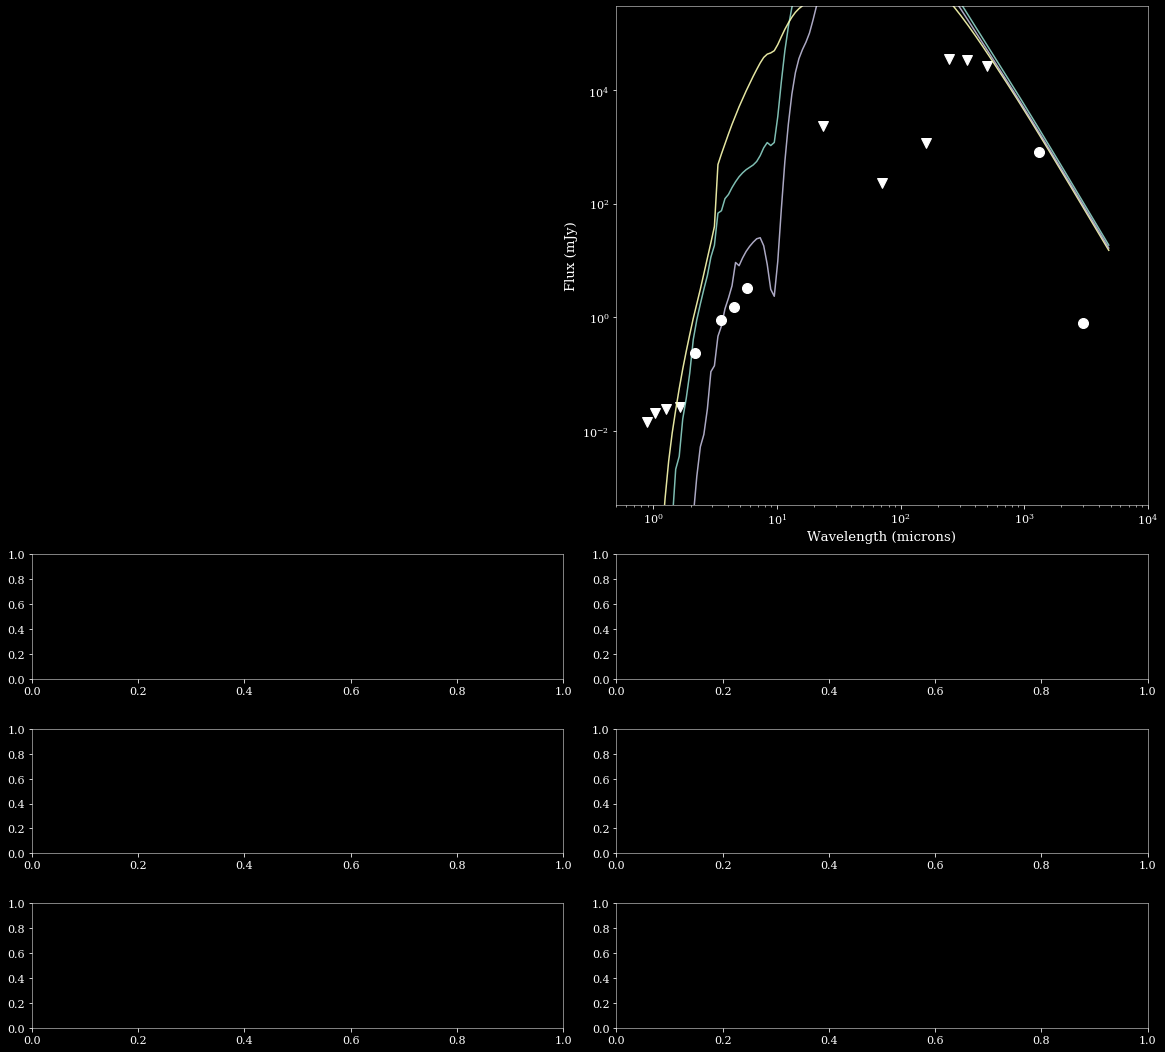

In [42]:
# Setting up the plot surface
basefig = plt.figure(figsize=(20, 22))
gs = GridSpec(nrows=5, ncols=2, height_ratios=[4,1,1,1,1], hspace=0.25, wspace=0.1)

# --------------------------------

# Best fits plot
ax0 = basefig.add_subplot(gs[0, 1])
wavelengths = u.Quantity([wavelength_dict[fn] for fn in filters], u.um)
ax0.errorbar(wavelengths.value[valid==1], source.flux[valid==1], yerr=source.error[valid==1], linestyle='none', color='w', marker='o', markersize=10)
ax0.plot(wavelengths.value[valid==3], source.flux[valid==3], linestyle='none', color='w', marker='v', markersize=10)

distance = 2*u.kpc

for geom in geometries_selection:
    global sedcube
    
    apnum = np.argmin(np.abs((3*u.arcsec * 2*u.kpc).to(u.au, u.dimensionless_angles()) - sedcube.apertures))
    fitinfo = bestfits_source[geom]
    
    model_dir = f'{robitaille_modeldir}/{geom}'
    sedcube = SEDCube.read(f"{model_dir}/flux.fits",)
    
    index = np.nanargmin(fitinfo.chi2)
    modelname = fitinfo.model_name[index]
    sed = sedcube.get_sed(modelname)
    _=ax0.plot(sedcube.wav,
             sed.flux[apnum] * fitinfo.sc[index] * 10**(fitinfo.av[index] * extinction.get_av(sed.wav)),
             label=geom, alpha=0.9)
    
ax0.loglog()
ax0.set_xlabel('Wavelength (microns)')
ax0.set_ylabel("Flux (mJy)")
ax0.set_xlim(0.5,1e4)
ax0.set_ylim(5e-4,3e5)

# --------------------------------

# ax1 = stellar temperature
# ax2 = model luminosity

# ax3 = stellar radius
# ax4 = line-of-sight mass

# ax5 = disk mass
# ax6 = sphere mass

ax1 = basefig.add_subplot(gs[1, 0])
ax2 = basefig.add_subplot(gs[1, 1])
ax3 = basefig.add_subplot(gs[2, 0])
ax4 = basefig.add_subplot(gs[2, 1])
ax5 = basefig.add_subplot(gs[3, 0])
ax6 = basefig.add_subplot(gs[3, 1])

histalpha = 0.8
lognum = 25
linnum = 25

aperturenum = 0

tempbins = binsfunction('star.temperature', 'lin', linnum, chi2limit, geometries_selection, bestfits_source)
lumbins = binsfunction('Model Luminosity', 'log', lognum, chi2limit, geometries_selection, bestfits_source)
radbins = binsfunction('star.radius', 'log', lognum, chi2limit, geometries_selection, bestfits_source)
losbins = binsfunction('Line-of-Sight Masses', 'log', 20, chi2limit, geometries_selection, bestfits_source, aperturenum)
dscbins = binsfunction('disk.mass', 'log', lognum, chi2limit, geometries_selection, bestfits_source)
sphbins = binsfunction('Sphere Masses', 'log', 20, chi2limit, geometries_selection, bestfits_source, aperturenum)

for geom in geometries_selection:
    pars, data = datafunction(geom, chi2limit, bestfits_source)

    if 'star.temperature' in pars.keys():
        ax1.hist(data['star.temperature'], bins=tempbins, alpha=histalpha, label=geom)

    if 'Model Luminosity' in pars.keys():
        ax2.hist(data['Model Luminosity'], bins=lumbins, alpha=histalpha, label=geom)

    if 'star.radius' in pars.keys():
        ax3.hist(data['star.radius'], bins=radbins, alpha=histalpha, label=geom)

    if 'Line-of-Sight Masses' in pars.keys():
        ax4.hist(data['Line-of-Sight Masses'][aperturenum], bins=losbins, alpha=histalpha, label=geom)
        
    if 'disk.mass' in pars.keys():
        ax5.hist(data['disk.mass'], bins=dscbins, alpha=histalpha, label=geom)
        
    if 'Sphere Masses' in pars.keys():
        ax6.hist(data['Sphere Masses'][aperturenum], bins=sphbins, alpha=histalpha, label=geom)

handles, labels = ax1.get_legend_handles_labels()
ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.16,1.02))
ax1.set_xlabel("Stellar Temperature (K)")
ax2.set_xlabel("Stellar Luminosity (L$_\odot$)")
ax3.set_xlabel("Stellar Radius (R$_\odot$)")
ax4.set_xlabel("Line-of-Sight Masses (M$_\odot$)")
ax5.set_xlabel("Disk Mass (M$_\odot$)")
ax6.set_xlabel("Sphere Mass (M$_\odot$)")

_=ax2.semilogx()
_=ax3.semilogx()
_=ax4.semilogx()
_=ax5.semilogx()
_=ax6.semilogx()

# --------------------------------

# reading the saved image of the region with source location marked
locfig = mpimg.imread(f'/home/btingle/figures/{fieldid}_{spicyid}.png')

# my image needs to be flipped
locfig = np.flipud(locfig)

ax9 = basefig.add_subplot(gs[0, 0])
ax9.imshow(locfig)
ttl = ax9.set_title(f'\n{fieldid}  |  SPICY {spicyid}\n', fontsize=25)
ttl.set_position([.5, 1])
#ax9.axis([90,630,90,630])
ax9.axis([170,550,170,550])
ax9.axis('off')